### Imports 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Activation, Conv2DTranspose, ReLU, Flatten, Dense
from tensorflow.keras.initializers import RandomNormal, Constant

import os 
from PIL import Image


strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


### Check which device is selected for training


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    print("Using GPU for training.")
else:
    print("No GPUs available. Using CPU for training.")


No GPUs available. Using CPU for training.


In [3]:
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")
 
# Printing the DeviceSpec 
print('Device Spec: ', device_spec.to_string())

Device Spec:  /job:localhost/replica:0/device:GPU:*


### Dataset params

In [4]:
batch_size = 32
img_size = (128,128)

### Load dataset

In [5]:
def show_images(images, num_images=16):
    images = (images + 1.0) / 2.0  # Denormalize to range [0, 1]
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

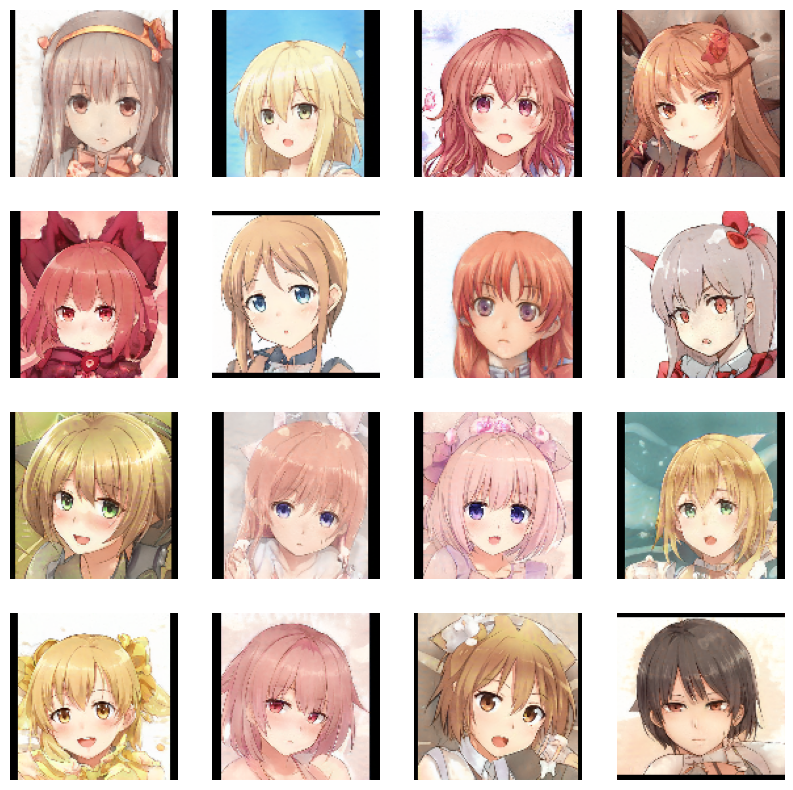

In [6]:
class AnimeDataset(tf.data.Dataset):

    def __new__(cls, img_dir, batch_size=32, img_size=(64, 64)):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        
        img_list = [os.path.join(abspath, path) for path in path_list if path.endswith('.png')]
        
        def load_and_preprocess_image(path):
            # Load image
            img = load_img(path, target_size=img_size)
            img = img_to_array(img)
            # Normalize to range [-1, 1]
            img = (img / 127.5) - 1.0
            return img
        
        # Create a TensorFlow Dataset
        dataset = tf.data.Dataset.from_tensor_slices(img_list)
        dataset = dataset.map(lambda path: tf.numpy_function(load_and_preprocess_image, [path], tf.float32),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

 
img_dir = './images/'   

with strategy.scope():
    dataset = AnimeDataset(img_dir, img_size=img_size, batch_size=batch_size)

# To check the dataset
for batch in dataset.take(1):
    show_images(batch.numpy())

### Generator Model

In [7]:
def build_generator():
    model = tf.keras.models.Sequential()
    
    # Initial dense layer
    model.add(layers.Dense(8 * 8 * 1024 , use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    input_channels = img_size[0]
    # Reshape into a feature map of size 8x8 with 256 channels
    model.add(layers.Reshape((8, 8, 1024)))
    
    #  8x8x1024 --> 16x16x512
    model.add(layers.Conv2DTranspose(input_channels * 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 16x16x512 --> 32x32x256
    model.add(layers.Conv2DTranspose(input_channels  * 2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 32x32x256 --> 64x64x128
    model.add(layers.Conv2DTranspose(input_channels, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
     # 64x64x128 --> 128x128x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsampling to 64x64
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    
    return model

 
# Initialize generator
with strategy.scope():
    generator = build_generator()

# Display summary
generator.summary()

c:\Users\vinew\anaconda3\envs\anime_gan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │     6,553,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 512)    │    13,107,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 64)   │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,232,384 (92.44 MB)

 Trainable params: 24,099,392 (91.93 MB)

 Non-trainable params: 132,992 (519.50 KB)

### Discriminator Model

In [8]:
def build_discriminator():
    
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))

    # First convolutional block
    x = Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Second convolutional block
    x = Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Additional convolutional blocks
    x = Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    x = Conv2D(512, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = Flatten()(x)

    # Logits and sigmoid output
    logits = Dense(1, activation=None, name='logits')(x)
    outputs = Activation('sigmoid')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


with strategy.scope():
    discriminator = build_discriminator()

 
discriminator.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,317,402 (16.47 MB)

 Trainable params: 4,315,610 (16.46 MB)

 Non-trainable params: 1,792 (7.00 KB)

Create logits model to extruct logits from discriminator

In [9]:
logits_model = tf.keras.Model(inputs=discriminator.input, outputs=discriminator.get_layer('logits').output)

### Training hyperparameters

In [10]:
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Create a batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = tf.random.normal([batch_size, 100, 1, 1])

 
real_label = 1.0
fake_label = 0.0

clipvalue = 1.0 
# Setup Adam optimizers for both G and D
lr_D = 0.00005 
lr_G = 2e-4 # Learning rate
beta1 = 0.5  # First moment decay rate
LAMBDA = 10
with strategy.scope(): 
    optimizerD = tf.optimizers.Adam(learning_rate=lr_D, beta_1=beta1, beta_2=0.999 , clipvalue= clipvalue)
    optimizerG = tf.optimizers.Adam(learning_rate=lr_G, beta_1=beta1, beta_2=0.999, clipvalue=clipvalue)

### Loss functions 

In [11]:
with strategy.scope(): 
        def calculate_loss( output, labels):
                criterion = tf.keras.losses.BinaryCrossentropy(from_logits=False)
                return criterion(labels, output)
with strategy.scope(): 
        def real_loss( d_logits, d_model):
                
                return  tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits,
                                                     labels=tf.ones_like(d_model)))
    
with strategy.scope(): 
       def fake_loss( d_logits, d_model):
                
                return  tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits,
                                                     labels=tf.zeros_like(d_model)))
with strategy.scope(): 
        def noise( size):
                z = tf.random.uniform(minval=-1, maxval=1, shape=(batch_size,100))
                return tf.convert_to_tensor(z, dtype=tf.float32)
        
with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
                loss = tf.reduce_mean(tf.abs(real_image - same_image))
                return LAMBDA * 0.5 * loss

### Create a DCGAN model 

In [12]:
class DCGan(keras.Model):
    def __init__(
        self,
        anime_generator,
        anime_discriminator,
       
    ):
        
        super(DCGan, self).__init__()
        self.anime_generator = anime_generator
        self.anime_discriminator = anime_discriminator


    def compile(
            self,
            discriminator_optimazer,
            generator_optimazer,
            noise ,
            real_loss,
            fake_loss,
            logits_model = logits_model,
           
    ):
        super(DCGan,self).compile()
        self.discriminator_optimazer = discriminator_optimazer
        self.generator_optimazer = generator_optimazer
        self.real_loss = real_loss
        self.fake_loss = fake_loss 
        self.noise = noise
        self.logits_model = logits_model
         
 
    
    def train_generator(self, g_optim, size):
         
        with tf.GradientTape() as tape:
            
            z = self.noise(size)
             
            fake_images = self.anime_generator(z)
            
            d_fake = self.anime_discriminator(fake_images)
            d_fake_logits = self.logits_model(fake_images)
            g_loss = self.real_loss(d_fake_logits, d_fake)

            g_loss = g_loss 
        
        gradients = tape.gradient(g_loss, self.anime_generator.trainable_variables)
        
        g_optim.apply_gradients(zip(gradients, self.anime_generator.trainable_variables))

        return g_loss 
    
    def train_discriminator(self, disc_opt, real_image, size): 

        with tf.GradientTape() as tape:
            
             
            real_img = self.anime_discriminator(real_image)
            d_reak_loss = self.logits_model(real_image)
            real_losses = self.real_loss(d_reak_loss, real_img)

            random_noise = self.noise(size)

            fake_img = self.anime_generator(random_noise)

            d_fake = self.anime_discriminator(fake_img)
            d_fake_logits = self.logits_model(fake_img)

            d_fake_loss = self.fake_loss(d_fake_logits , d_fake)

            d_loss = real_losses + d_fake_loss

            d_loss = d_loss * 0.5

        gradients = tape.gradient(d_loss, self.anime_discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(gradients, self.anime_discriminator.trainable_variables))

        return d_loss 

    

    def train_step(self, data):
        real_images = data
        batch_size = tf.shape(real_images)[0]
        
         
        d_loss = self.train_discriminator(self.discriminator_optimazer, real_images, batch_size)
         
        g_loss = self.train_generator(self.generator_optimazer, batch_size)
        
        return {'discriminator_loss': d_loss, 'generator_loss': g_loss}
        
         

### Here you can load any checkpoints

In [13]:
checkpoint = 0
if checkpoint != 0: 
    discriminator.load_weights(f"./checkpoints/discriminator_7_{checkpoint}.h5")
    generator.load_weights(f"./checkpoints/generator_7_{checkpoint}.h5")

### Customs checkpoints to save the weights during model training

In [14]:
class CustomModelCheckpoint(Callback):
    def __init__(self, save_freq, checkpoint_dir, checkpoint):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint = checkpoint

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            file_path = os.path.join(self.checkpoint_dir, f'generator_11_{self.checkpoint + epoch + 1}.h5')
            self.model.anime_generator.save_weights(file_path)
            file_path = os.path.join(self.checkpoint_dir, f'discriminator_11_{self.checkpoint + epoch + 1}.h5')
            self.model.anime_discriminator.save_weights(file_path)
            print(f'\nModel saved to {file_path}')

### Compile the model

In [15]:
with strategy.scope():

    DCGAN_M = DCGan(anime_discriminator=discriminator, anime_generator=generator)
    DCGAN_M.compile(
         discriminator_optimazer = optimizerD,
         generator_optimazer = optimizerG,
         real_loss = real_loss,
         fake_loss = fake_loss, 
         noise = noise,
         logits_model = logits_model
    )

### Initialize checkpoints and csv logger

In [16]:
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

custom_checkpoint_callback = CustomModelCheckpoint(save_freq=1, checkpoint_dir=checkpoint_dir, checkpoint=checkpoint)
 
csv_logger = CSVLogger('training_15_log.csv', append=True)



In [17]:
DCGAN_M.fit(
    dataset,
    epochs=215-checkpoint,   
    callbacks=[custom_checkpoint_callback , csv_logger] 
)

Epoch 1/215


ValueError: as_list() is not defined on an unknown TensorShape.

In [40]:
def generate_random_noise(batch_size, noise_dim):
    z = tf.random.uniform(minval=-1, maxval=1, shape=(batch_size,100))
    return tf.convert_to_tensor(z, dtype=tf.float32)

# Function to generate and visualize samples
def generate_and_visualize_samples(generator, noise_dim, num_samples):
    # Generate random noise
    random_noise = generate_random_noise(num_samples, noise_dim)
    
    # Generate images using the generator model
    generated_images = generator.predict(fixed_noise)
    
    # Check the shape of generated images
    print("Generated images shape:", generated_images.shape)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    
    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [41]:
noise_dim = 100
num_samples = 16

In [30]:
fixed_noise =  generate_random_noise(num_samples, noise_dim)

In [28]:
generator.load_weights("./checkpoints/generator_7_147.h5")

1/1 [==============================] - 0s 22ms/step
Generated images shape: (16, 128, 128, 3)


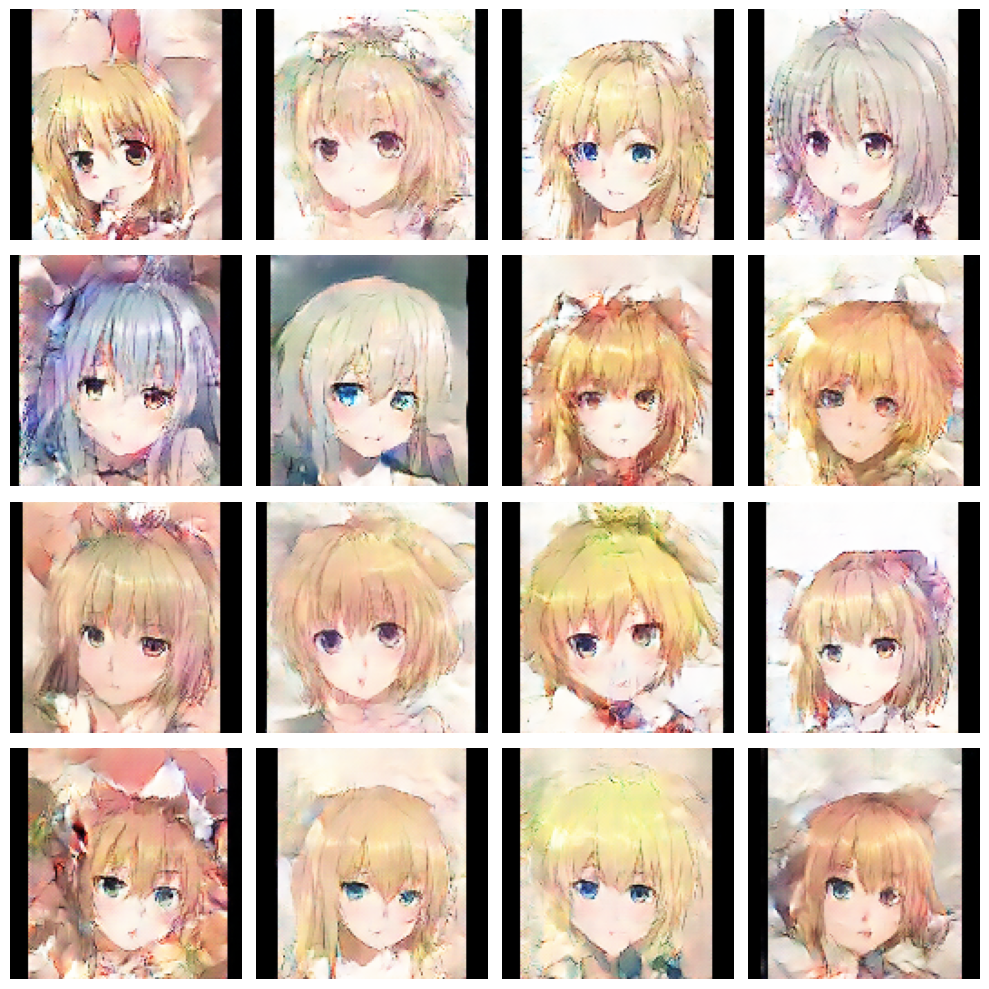

In [65]:
fixed_noise =  generate_random_noise(num_samples, noise_dim)

# Generate and visualize samples
generate_and_visualize_samples(generator, noise_dim, num_samples)